# Análise de Classificação

Este projeto é exclusivamente para fins educacionais com intuito de aprimorar minhas habilidades como cientista de dados.

Neste jupyter iremos trabalhar:

* **Limpeza e Transformação:** Um tratamento dos dados para que eles estejam estruturados o suficiente para análise (caso seja necessário).
* **Análise Exploratória:** Com intuito de entender melhor os dados que estamos trabalhando e observar como estão distribuidos.
* **Engenharia de Atributos:** Usaremos técnicas como One Hot Encoding, Label Encoding com intuito de preparar os dados para os modelos de regressão.
* **Seleção de Variáveis:**

## Definindo o Problema de Negócio

Os dados são de campanhas de marketing direto de uma instituição bancária. As campanhas foram baseadas em ligações telefônicas.
Muitas vezes era necessário mais do que um contacto com o mesmo cliente, para saber se depósito a prazo bancário seria ('sim') ou não ('não'). O objetivo desse projeto é prever se o cliente irá realizar (sim/não) um depósito a prazo (variável y).

Link do dataset: https://archive.ics.uci.edu/dataset/222/bank+marketing

## Carregando Pacotes

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

Importando dataset.

In [2]:
# df = pd.read_csv('dados/bank.csv', sep = ';')
df = pd.read_csv('dados/bank-full.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Data Wrangling

Agora iremos analizar e entender melhor os dados, para posteriormente fazer algumas manipulações e a engenharia de atributos.

In [3]:
# Verificando o número de linhas e colunas
df.shape

(45211, 17)

In [4]:
# Verificando se há valores nulos
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Sem dados faltantes.

In [5]:
# Verificando o tipo das variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [6]:
# Verificando se há registros duplicados.
df.duplicated().sum()

0

## EDA

Nesta etapa iremos plotar alguns gráficos para visualizar melhor a distribuição das variáveis.

**A variável target (y) está balanceada?**

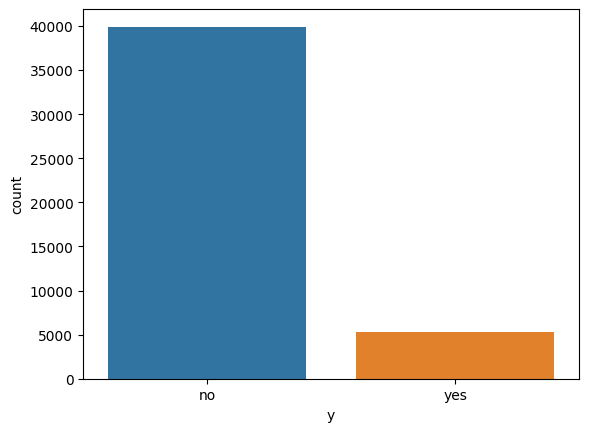

In [7]:
sns.countplot(df, x= 'y')
plt.show()

Será necessário aplicar uma técnica de balançeamento na variável target.

**Qual a variação da idade dos clisntes?**

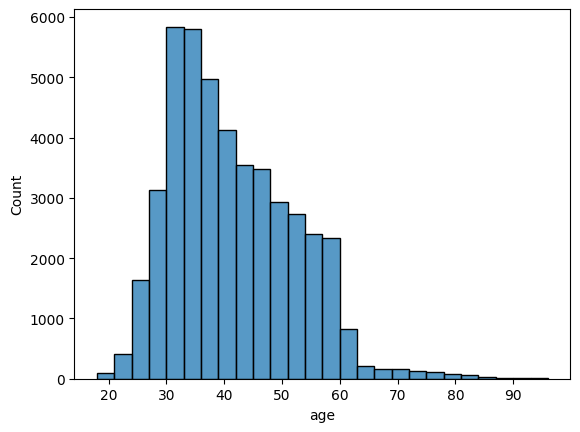

In [8]:
sns.histplot(data= df, x= 'age', binwidth= 3)
plt.show()

Observamos uma grande quantidade de clientes entre 30 e 40 anos.

**Qual é o nível de escolaridade dos clientes?**

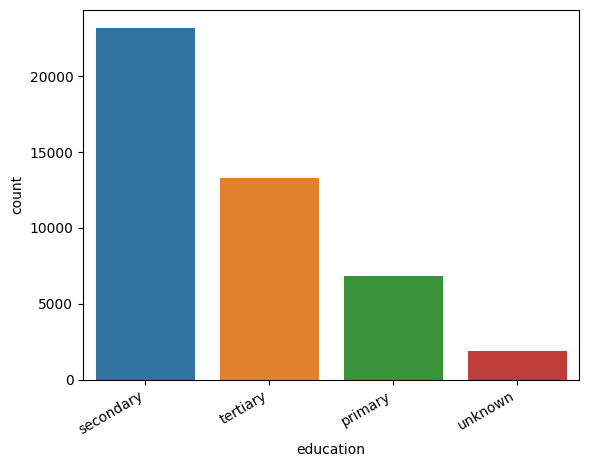

In [9]:
# Variável para ordernar o gráfico
ordem = df['education'].value_counts().index

# Plot
sns.countplot(df, x= 'education', order= ordem)

# Rotacionando os valores do eixo X
plt.xticks(rotation= 30, ha= 'right')
plt.show()

**Qual nível de escolaridade teve mais deposito a prazo?**

In [10]:
var = df.groupby(['education', 'y'])['y'].value_counts(normalize= True).reset_index()
var

,education,y,proportion
0,primary,no,1.0
1,primary,yes,1.0
2,secondary,no,1.0
3,secondary,yes,1.0
4,tertiary,no,1.0
5,tertiary,yes,1.0
6,unknown,no,1.0
7,unknown,yes,1.0


**O trabalho do cliente enfluencia no deposito a prazo?**

Observações: 

* Será necessário aplicar **One Hot Encodin** nas seguintes colunas: marital, education e contact.
* Será necessário aplicar **Label Enconder** nas seguintes colunas: default, housing, loane e a variável target (y).
* Na coluna month, iremos agrupar por trimestre e semestre.
* Precisaremos analisar a correlação das colunas campaign, pdays e previous com a variável target (y).

## Feature Engineering

In [11]:
df_copy = df.copy()

Primeiro vamos aplicar a **One Hot Encoding**.

In [12]:
df_copy = pd.get_dummies(df_copy, columns= ['marital', 'education', 'contact', 'poutcome'], dtype= 'int')

Agora a **Label Enconder**.

In [13]:
label = ['default', 'housing', 'loan', 'y']
df_copy[label] = np.where(df_copy[label] == 'yes', 1, 0)

Agora vamos separar os meses por Trimestre e Semestre.

In [14]:
# Dicionário para mapeamento
trimestres = {
    'jan': 1, 'fev': 1, 'mar': 1,
    'apr': 2, 'may': 2, 'jun': 2,
    'jul': 3, 'aug': 3, 'sep': 3,
    'oct': 4, 'nov': 4, 'dec': 4
}

# Criando nova coluna Quarter com os valores dos trimestres
df_copy['Quarter'] = df_copy['month'].map(trimestres).round(0)

# Aplicando One Hot Encoding
df_copy = pd.get_dummies(df_copy, columns= ['Quarter'], dtype= 'int')

In [15]:
# Dicionário de Mapeamento
semestres = {
    'jan': 1, 'fev': 1, 'mar': 1,
    'apr': 1, 'may': 1, 'jun': 1,
    'jul': 2, 'aug': 2, 'sep': 2,
    'oct': 2, 'nov': 2, 'dec': 2
}

# Criando nova coluna Semester com os valores dos semestrais
df_copy['Semester'] = df_copy['month'].map(semestres)

# Aplicando One Hot Encoding
df_copy = pd.get_dummies(df_copy, columns= ['Semester'], dtype= 'int')

In [16]:
# Excluindo a coluna de meses
df_copy.drop(columns = ['month'], inplace= True)

Por enquanto, este será o dataset final. Por fim, não iremos utilizar a variável job neste momento.

In [17]:
# Dataset final
df_final = df_copy.drop(columns = ['job'])

# Coletando x e y
X = df_final.drop(columns = ['y'])
y = df_final['y'].values

# Gerando número de observações e variáveis
observations = len(df_final)
variaveis = df_final.columns

## Seleção de Variáveis

Nesta etapa iremos fazer uma análise para selecionar as melhores variáveis para a interpetação dos modelos. Iremos realizar uma nálise de correlação para verificar se existe multicoliniaridade entre as variáveis.

### Análise de Correlação

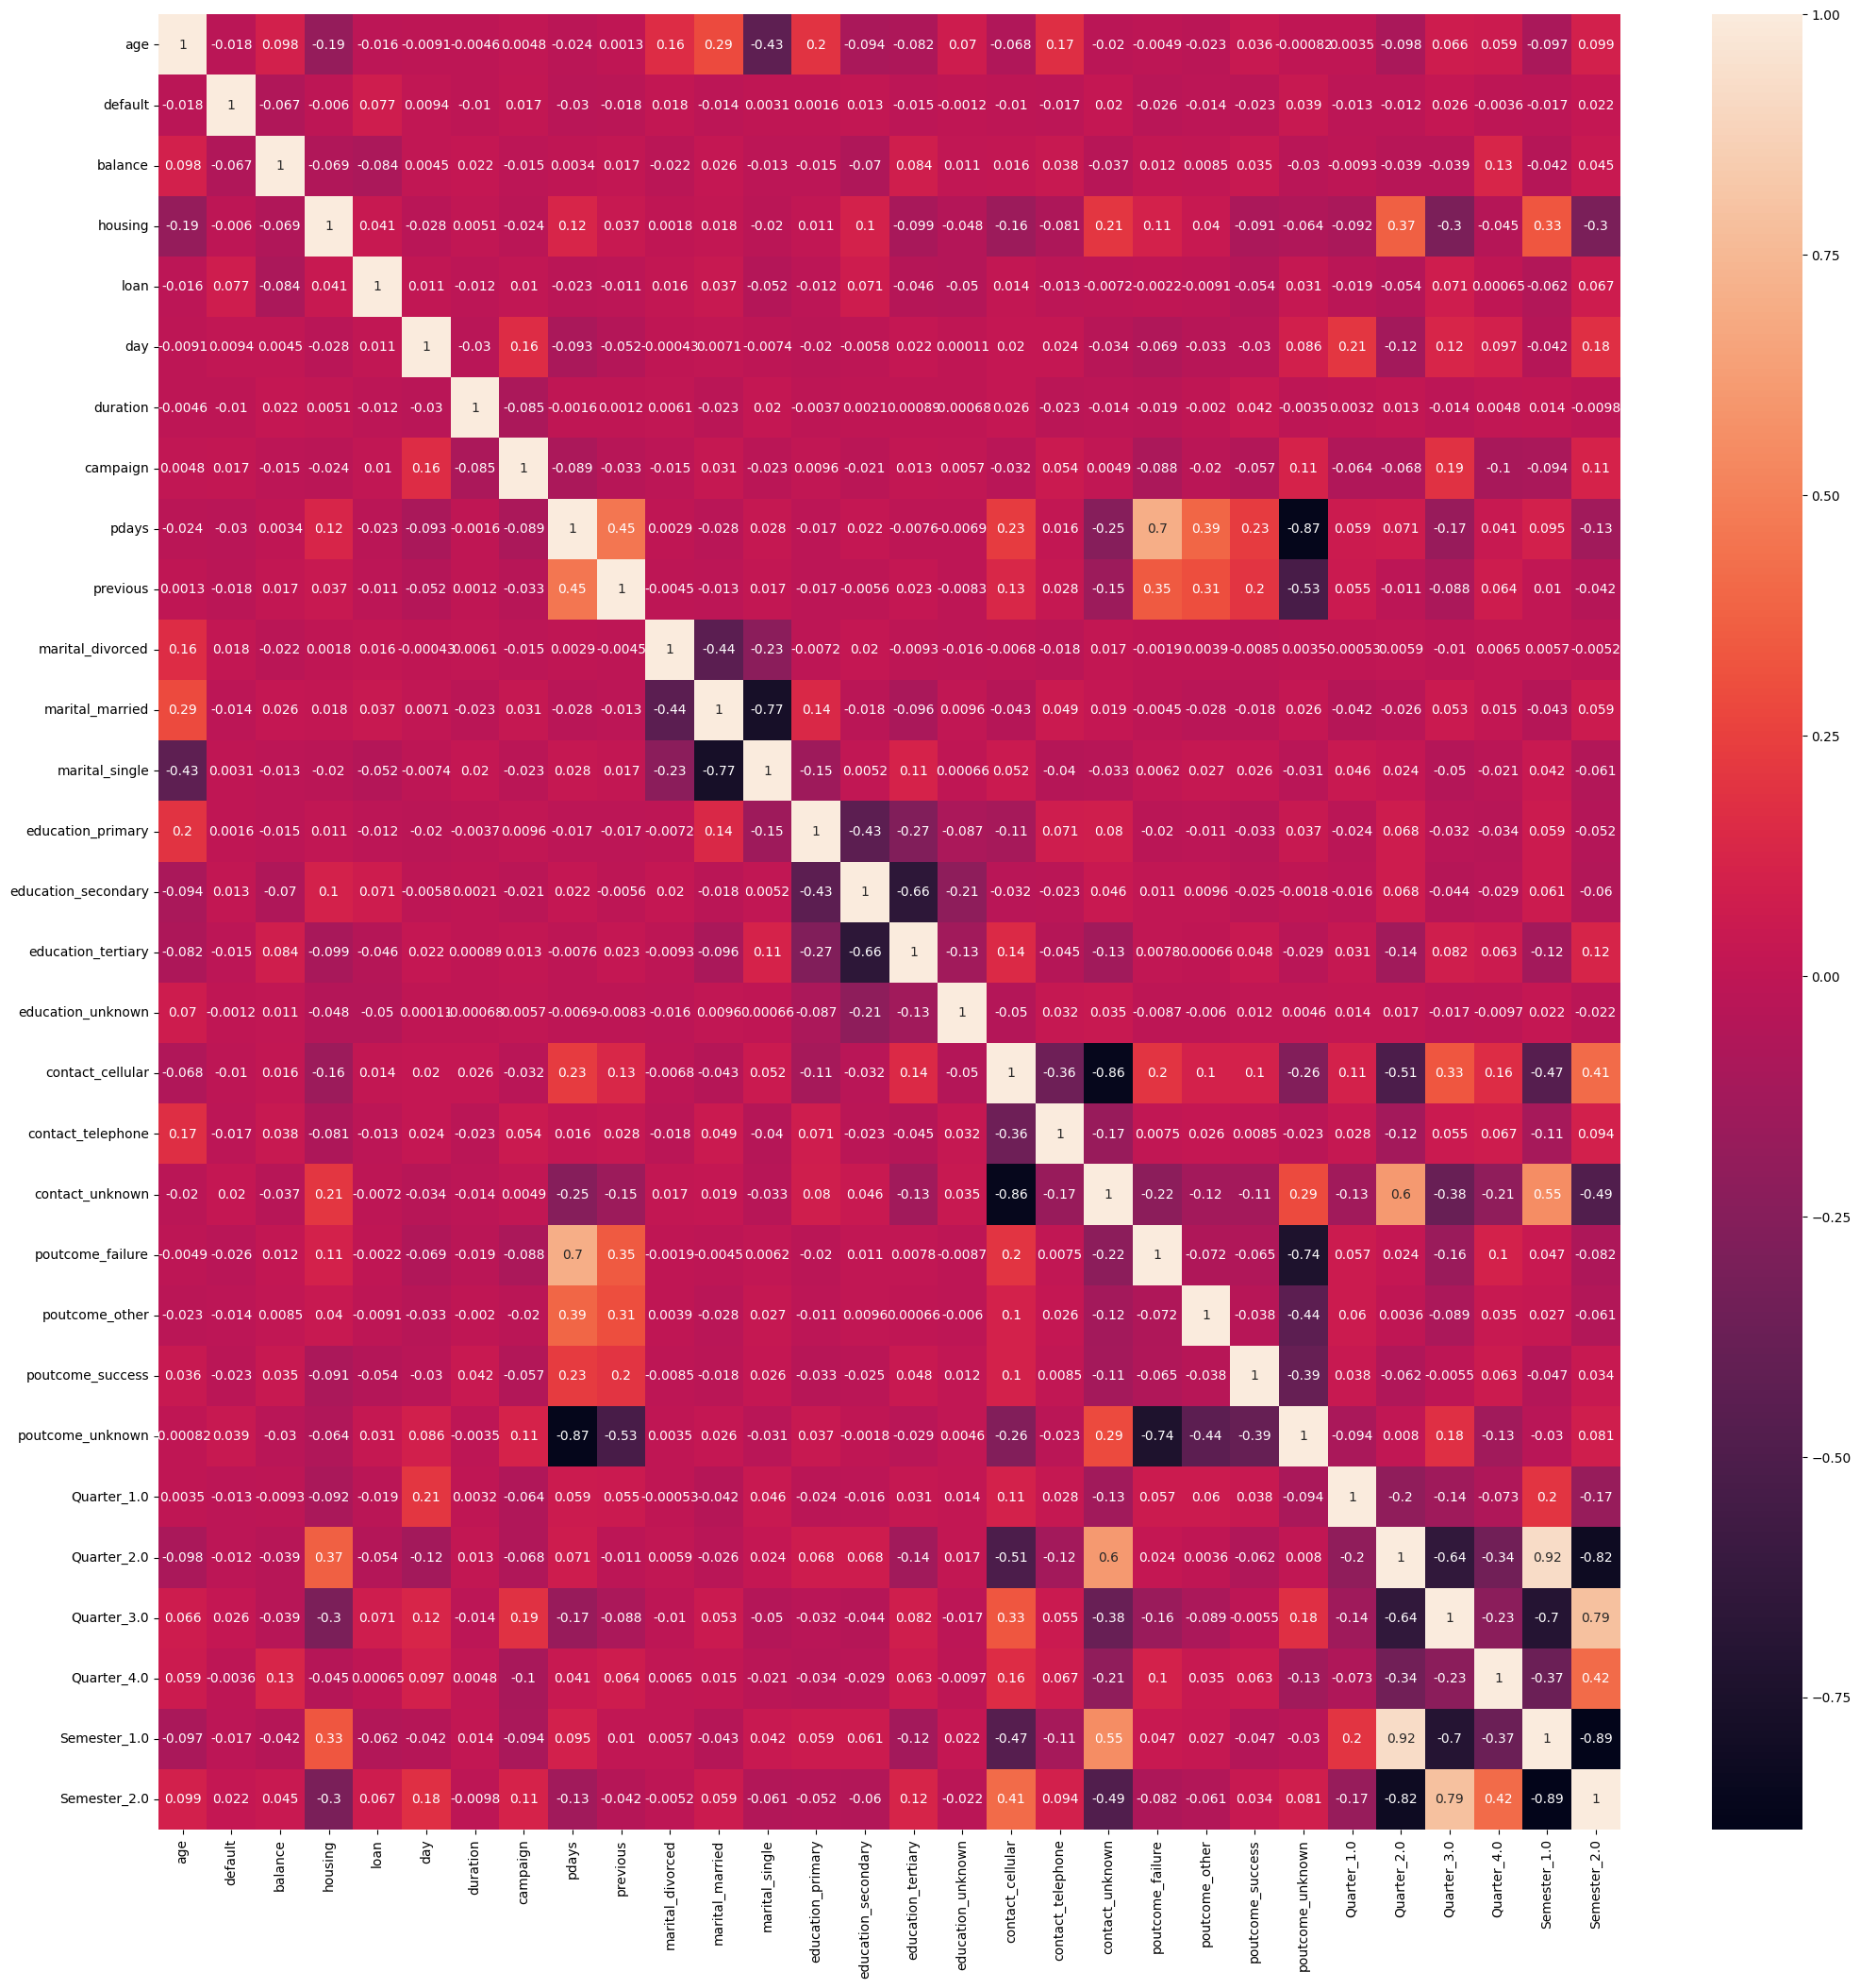

In [18]:
# Criando matriz de correlação
matriz_corr = df_final.drop(columns = ['y']).corr()

# Definindo o tamanho do gráfico
plt.figure(figsize= (25, 25))

# Plot
sns.heatmap(matriz_corr, annot= True)
plt.show()

Usaremos a técnica de autovalores e autovetores para verificar se há multicoliniaridade entre as variáveis.

In [19]:
# Gerando autovalores e autovetores
corr = np.corrcoef(df_final, rowvar = 0)
autovalores, autovetores = np.linalg.eig(corr)

In [20]:
np.set_printoptions(suppress= True)
print(autovalores)

[ 4.51949677  3.48060391  2.19819091  1.77584688  0.14288338  0.17793677
  1.5339666   0.50061843  0.54449744  0.57159162  0.64378825  1.38096224
  0.74683404  0.76435831  1.32205879  1.29032884  1.26026894  0.88151318
  0.92183403  1.11952771  1.10796837  0.9900748   1.01697606  1.04403205
  1.06384166  0.         -0.          0.          0.         -0.
 -0.        ]


In [21]:
print(autovetores[:,4])

[ 0.01101524 -0.00496086  0.00624431 -0.01900287  0.00180393  0.03714179
 -0.00333064 -0.00897688  0.76903562  0.06563362  0.0099296  -0.00556073
  0.00360993  0.00001794 -0.00888756 -0.00316752  0.01100707 -0.00123806
 -0.0130349  -0.01529559  0.02203421 -0.33318114 -0.20333874 -0.08001264
  0.40940042 -0.02645469 -0.13867504 -0.12466347 -0.0188871  -0.14944649
 -0.128385  ]


In [22]:
print(variaveis[8], variaveis[21], variaveis[22], variaveis[24], variaveis[26], variaveis[27], variaveis[29])

pdays poutcome_failure poutcome_other poutcome_unknown Quarter_2.0 Quarter_3.0 Semester_1.0
